In [3]:
import pandas as pd
import numpy as np
import torch

import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import tensorflow as tf

# define path to glove and snli files
path = "../Project/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
snli_train = pd.read_csv(path+'snli_1.0/snli_1.0_train.txt', sep="\\t")
snli_test = pd.read_csv(path+'snli_1.0/snli_1.0_test.txt', sep="\\t")
snli_dev = pd.read_csv(path+'snli_1.0/snli_1.0_dev.txt', sep="\\t")

C:\Users\Danie\Anaconda3\envs\gameAI\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
C:\Users\Danie\Anaconda3\envs\gameAI\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
C:\Users\Danie\Anaconda3\envs\gameAI\lib\site-packages\ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine=

In [5]:
print(snli_train['sentence1'][0],snli_train['sentence2'][0], snli_train['gold_label'][0])
print(snli_train['sentence1'][1],snli_train['sentence2'][1], snli_train['gold_label'][1])
print(snli_train['sentence1'][2],snli_train['sentence2'][2], snli_train['gold_label'][2])

A person on a horse jumps over a broken down airplane. A person is training his horse for a competition. neutral
A person on a horse jumps over a broken down airplane. A person is at a diner, ordering an omelette. contradiction
A person on a horse jumps over a broken down airplane. A person is outdoors, on a horse. entailment


In [6]:
# Filter and rename the important columns
train_df = snli_train.filter(['sentence1','sentence2','gold_label'], axis=1)
test_df = snli_test.filter(['sentence1','sentence2','gold_label'], axis=1)
train_df = train_df.rename(columns={"sentence1": "premise", "sentence2": "hypothesis"})
test_df = test_df.rename(columns={"sentence1": "premise", "sentence2": "hypothesis"})

In [7]:
# exclude sentences which could not be categorised
train_df = train_df[train_df['gold_label'] != "-"]
test_df = test_df[test_df['gold_label'] != "-"]

In [8]:
test_df['gold_label'].value_counts()

entailment       3368
contradiction    3237
neutral          3219
Name: gold_label, dtype: int64

# Glove

In [9]:
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [10]:
embeddings_dict = {}
with open(path+"glove.6B.300d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [11]:
def find_closest_embeddings(embedding):
    return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embedding))
find_closest_embeddings(embeddings_dict["king"])[1:5]

['queen', 'monarch', 'prince', 'kingdom']

# Sentence embeddings

In [12]:
# Following guide https://medium.com/@sarin.samarth07/glove-word-embeddings-with-keras-python-code-52131b0c8b1d
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.layers import Dense, Embedding, Input, Add, Dot, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.sequence import skipgrams
from tensorflow.python.keras.models import Model, load_model

In [13]:
def get_embedding_matrix(series):
    series = series.astype(str)

    token = Tokenizer()
    token.fit_on_texts(series)
    seq = token.texts_to_sequences(series)

    print(series[0])
    print(seq[0])

    print("the max sentence length is:",max([len(x) for x in seq]))
    pad_seq = pad_sequences(seq,maxlen=100)
    vocab_size = len(token.word_index)+1
    print(vocab_size)

    embedding_matrix = np.zeros((vocab_size,300))
    for word,i in token.word_index.items():
        embedding_value = embeddings_dict.get(word) #using glove embedding for each word
        if embedding_value is not None:
            embedding_matrix[i] = embedding_value

    # Sum embeddings of words together to get embedding of sentence (baseline sentence embedding model)
    print(pad_seq[4])
    return pad_seq, embedding_matrix, vocab_size
    

In [14]:
pad_seq_prem, embedding_matrix_prem, vocab_size_prem = get_embedding_matrix(train_df['premise'])

A person on a horse jumps over a broken down airplane.
[1, 56, 5, 1, 197, 191, 68, 1, 1762, 36, 877]
the max sentence length is: 78
18490
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0  59 132   4 666  16  94]


In [15]:
pad_seq_hyp, embedding_matrix_hyp, vocab_size_hyp = get_embedding_matrix(train_df['hypothesis'])

A person is training his horse for a competition.
[1, 27, 3, 821, 16, 162, 20, 1, 275]
the max sentence length is: 56
30904
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0  22   4  40 705]


# Baseline
### Sum embeddings of all words in a sentence together to get the complete embedding

In [16]:
def baseline_sum_sentence_embeddings(pad_seq, embedding_matrix):
    # Sum embeddings of words together to get embedding of sentence (baseline sentence embedding model)
    sentence_embs = []
    for i in pad_seq:
        sentence_embs.append(sum([embedding_matrix[x] for x in i]))
    sentence_embs = np.array(sentence_embs)
    return sentence_embs

In [17]:
sentence_embs = baseline_sum_sentence_embeddings(pad_seq_prem, embedding_matrix_prem)

In [18]:
sentence_embs_hyp = baseline_sum_sentence_embeddings(pad_seq_hyp, embedding_matrix_hyp)

# Model

In [19]:
import keras
from keras import datasets, layers, models


#model
# shape represents 300d glove embedding of sentence 
shape=(300)

premise= layers.Input(shape=shape)
hypothesis= layers.Input(shape=shape)

xp=layers.Dense(100,activation='tanh')(premise)
xh=layers.Dense(100,activation='tanh')(hypothesis)

conc=layers.concatenate([xp,xh])

y= layers.Dense(300,activation='tanh')(conc)
y= layers.Dense(300,activation='tanh')(y)
y= layers.Dense(300,activation='tanh')(y)

output=layers.Flatten()(y)
output = layers.Dense(3, activation='softmax')(output)

model = keras.models.Model([premise,hypothesis], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          30100       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          30100       input_2[0][0]                    
______________________________________________________________________________________________

# Train

In [20]:
model.compile(optimizer='Adadelta',loss='categorical_crossentropy',metrics = ['accuracy'])

In [21]:
from sklearn.preprocessing import OneHotEncoder
def encode_labels(gold_label):
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(np.array(gold_label).reshape(-1, 1))

    print(enc.categories_)

    enc_gold_label = enc.transform(np.array(gold_label).reshape(-1, 1)).toarray()

    print(enc_gold_label[2])
    return enc_gold_label

In [22]:
enc_gold_label = encode_labels(train_df['gold_label'])

[array(['contradiction', 'entailment', 'neutral'], dtype=object)]
[0. 1. 0.]


In [23]:
history = model.fit([np.array(sentence_embs[0:300000]), np.array(sentence_embs_hyp[0:300000])],enc_gold_label[0:300000],epochs = 40,batch_size=256,validation_split=0.2, verbose=1)

Epoch 1/40
938/938 [==============================] - 11s 11ms/step - loss: 1.1345 - accuracy: 0.3496 - val_loss: 1.0900 - val_accuracy: 0.3902
Epoch 2/40
938/938 [==============================] - 9s 10ms/step - loss: 1.0837 - accuracy: 0.4028 - val_loss: 1.0656 - val_accuracy: 0.4310
Epoch 3/40
938/938 [==============================] - 10s 11ms/step - loss: 1.0620 - accuracy: 0.4379 - val_loss: 1.0496 - val_accuracy: 0.4561
Epoch 4/40
938/938 [==============================] - 11s 12ms/step - loss: 1.0471 - accuracy: 0.4585 - val_loss: 1.0383 - val_accuracy: 0.4708
Epoch 5/40
938/938 [==============================] - 9s 9ms/step - loss: 1.0340 - accuracy: 0.4740 - val_loss: 1.0292 - val_accuracy: 0.4804
Epoch 6/40
938/938 [==============================] - 9s 9ms/step - loss: 1.0274 - accuracy: 0.4802 - val_loss: 1.0221 - val_accuracy: 0.4884
Epoch 7/40
938/938 [==============================] - 9s 10ms/step - loss: 1.0200 - accuracy: 0.4872 - val_loss: 1.0162 - val_accuracy: 0.493

In [24]:
model.save('baseline_300000_40epochs')

INFO:tensorflow:Assets written to: baseline_300000_40epochs\assets


# Test

In [25]:
pad_seq_prem_test, embedding_matrix_prem_test, vocab_size_prem_test = get_embedding_matrix(test_df['premise'])
pad_seq_hyp_test, embedding_matrix_hyp_test, vocab_size_hyp_test = get_embedding_matrix(test_df['hypothesis'])

sentence_embs_prem_test = baseline_sum_sentence_embeddings(pad_seq_prem_test, embedding_matrix_prem_test)
sentence_embs_hyp_test = baseline_sum_sentence_embeddings(pad_seq_hyp_test, embedding_matrix_hyp_test)

enc_gold_label_test = encode_labels(test_df['gold_label'])

This church choir sings to the masses as they sing joyous songs from the book at a church.
[281, 668, 779, 600, 12, 3, 2084, 42, 184, 1455, 2085, 2086, 64, 3, 272, 17, 1, 668]
the max sentence length is: 54
4093
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    1   10    9    1   43 1400   22   16    4    1  218
  282 2087]
The church has cracks in the ceiling.
[2, 655, 36, 2754, 6, 2, 2755]
the max sentence length is: 29
5166
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0

In [26]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate([sentence_embs_prem_test, sentence_embs_hyp_test], enc_gold_label_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
77/77 [==============================] - ETA: 0s - loss: 0.9396 - accuracy: 0.55 - 0s 3ms/step - loss: 0.9368 - accuracy: 0.5545
test loss, test acc: [0.9368278384208679, 0.5544584393501282]


In [27]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict([sentence_embs_prem_test, sentence_embs_hyp_test])
print("predictions shape:", predictions.shape)

Generate predictions for 3 samples
predictions shape: (9824, 3)


In [28]:
pd.DataFrame.from_dict(history.history).to_csv('baseline_history_300000_40epochs.csv',index=False)

In [29]:
test_results_baseline = pd.DataFrame(predictions)
test_results_baseline.to_csv("Baseline_test_results_300000_40epochs.csv")

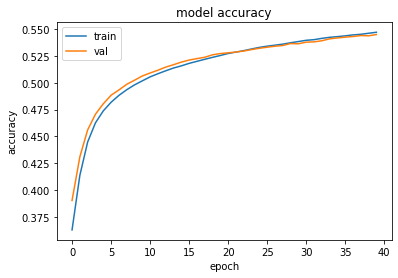

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.show()